## Localização de Caracteres através de suas Coordenadas
O objetivo deste desafio é desenvolver um modelo que recebe como entrada uma imagem contendo caracteres e retorna a localização desses. A pipeline idealizada é simples: são aplicados dois filtros consecutivos na imagem, *gray-scale* e *threshold_binary_inv*. Essa conversão ressalta o formato dos caracteres, levando cada pixel a valores nulos ou máximos (255), a partir de um *threshold* estabelecido. Em seguida, as coordenadas dos pixels identificados como parte de caracteres (com valor 255) são armazenadas em um DataFrame. Por fim, é aplicado um algoritimo de aprendizado não-supervisionado *KMeans* sobre as coordenadas obtidas. Os centros de cada *cluster KMeans* se aproximam dos centros de cada caracter.

**LIMITAÇÕES**
1. O número de *clusters kmeans* deve ser estabelecido *a priori*. O número de *clusters* deve ser igual ao número de caractéres na imagem, isso requer um ajuste manual com conhecimento prévio da imagem.
2. Caractéres largos, como a letra 'O', tendem a ser separados em clusters distintos, principalmente se estiverem próximos de caractéres estreitos, como a letra 'I'. Esse problema é facilmente percebido na palavra *proibido* (checar imagem na pasta *goalImages*).
3. O filtro *threshold_binary_inv* pode ressaltar ou dissolver o formato dos caracteres, a depender do *threshold* estabelecido *a priori*. Foi necessário um ajuste manual no modelo implementado.

Para a limitação em 1, foi proposta uma solução a partir da métrica *WCSS (Within-Cluster Sum of Square)*, a soma quadrática das distâncias entre cada ponto e o centroide do cluster associado ao ponto. *Clusters* estáveis resultam em baixos WCSS. Foram treinados n Kmeans variando-se o número de *clusters* para cada imagem. O WCSS foi plotado em um gráfico. O número de *clusters* ideal é escolhido quando a métrica WCSS se estabiliza, observar gráficos na pasta *wcssMetric*. Como esperado, a métrica se estabiliza quando o número de *clusters* coincide com o número de caracteres da imagem.

As coordenadas dos caracteres das imagens estão no arquivo *center_coordinates.txt*.

In [8]:
import cv2
import numpy as np
import pandas as pd

import os
import shutil


import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

sbn.set_style("whitegrid")

In [9]:
def save_images(images, image_names, path, ext='.jpg'):
    for image, name in zip(images, image_names):
        print(f"saved at {path+name+ext}")
        cv2.imwrite(path+name+ext, image)
    

def view_images(images):
    n = len(images)
    fig, ax = plt.subplots(int(n/2), 2)
    fig.set_figheight(n)
    
    for i in range(n):
        ax[i//2][i%2].imshow(images[i])
    
    plt.show()

def get_coordinates(image):
    coordinates = []

    rows, cols = image.shape
    for row in range(rows):
        for col in range(cols):
            if image[row, col] == 255:
                coordinates.append([row, col])
    
    return np.array(coordinates)

def draw_centers(centers, image):
    for center in centers.tolist():
        x,y = center
        
        image[x, y] = (255, 0, 0)
        image[x-1, y-1] = (255, 0, 0)
        image[x+1, y+1] = (255, 0, 0)
        image[x-1, y+1] = (255, 0, 0)
        image[x+1, y-1] = (255, 0, 0)
    
    return image

def write_centers(names, all_centers):
    with open('centers_coordinates.txt', 'w') as file:
        for centers, name in zip(all_centers, names):
            centers_str = np.array2string(centers, separator=' ')
            file.write(f"Image Name: {name}\n")
            file.write(f"{centers_str}\n")
            file.write('-'*100)


def main(thresh_images, original_images, ks):
    goal_images, all_centers = [], []
    for index, thresh_image in enumerate(thresh_images):
        coordinates = pd.DataFrame(get_coordinates(thresh_image), columns=['row', 'col'])
        kmeans = KMeans(ks[index])
        kmeans.fit(coordinates)
        centers = kmeans.cluster_centers_.astype('int32')
        all_centers.append(centers)  
        goal_images.append(draw_centers(centers, original_images[index]))
    
    write_centers(image_names, all_centers)
    
    return goal_images

In [10]:
# Image Path
image_paths =['./originalImages/' + path for path in os.listdir('./originalImages/') if ('.png' in path)]
image_names = ['santos', '1996', 'proibido', 'sao', 'reis', 'paulo']

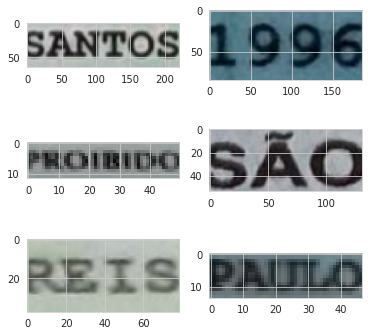

In [11]:
# Load Original Image
original_images = [cv2.imread(path) for path in image_paths]
view_images(original_images)

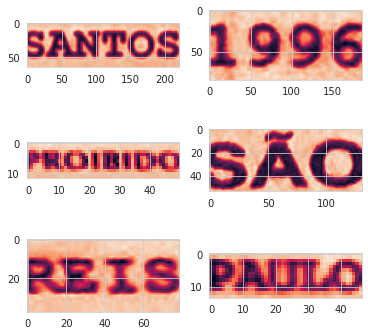

In [12]:
# Converting to gray-scale
gray_images = [cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY) for original_image in original_images]
view_images(gray_images)

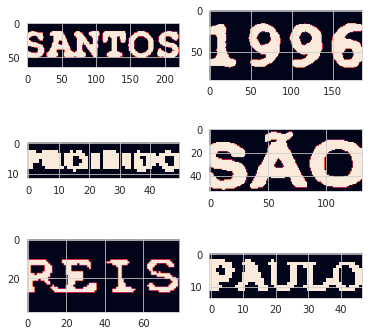

In [13]:
# Threshold Method
thrs = [120, 80, 120, 120, 120, 70]
thresh_images = [cv2.threshold(gray_image, thr, 255, cv2.THRESH_BINARY_INV)[1] for gray_image, thr in zip(gray_images, thrs)]
view_images(thresh_images)

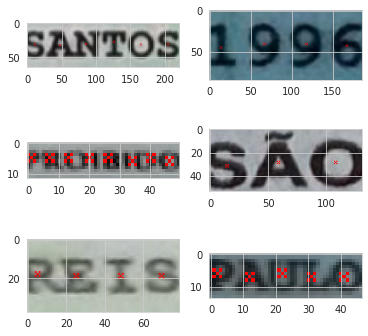

In [14]:
# Draw Centers
goal_images = main(thresh_images, original_images, ks=[6, 4, 8, 3, 4, 5])
view_images(goal_images)

In [15]:
def mkdir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    
mkdir('./grayImages')
mkdir('./thresholdImages')
mkdir('./goalImages')

save_images(gray_images, image_names, './grayImages/', ext='.jpg')
save_images(thresh_images, image_names, './thresholdImages/', ext='.jpg')
save_images(goal_images, image_names, './goalImages/', ext='.jpg')

saved at ./grayImages/santos.jpg
saved at ./grayImages/1996.jpg
saved at ./grayImages/proibido.jpg
saved at ./grayImages/sao.jpg
saved at ./grayImages/reis.jpg
saved at ./grayImages/paulo.jpg
saved at ./thresholdImages/santos.jpg
saved at ./thresholdImages/1996.jpg
saved at ./thresholdImages/proibido.jpg
saved at ./thresholdImages/sao.jpg
saved at ./thresholdImages/reis.jpg
saved at ./thresholdImages/paulo.jpg
saved at ./goalImages/santos.jpg
saved at ./goalImages/1996.jpg
saved at ./goalImages/proibido.jpg
saved at ./goalImages/sao.jpg
saved at ./goalImages/reis.jpg
saved at ./goalImages/paulo.jpg


In [16]:
# Identificação Automática do Número de Clusters
#Modelo KMean + WCSS
def show_wcss(thresh_images, max_k=10):
    mkdir('./wccsMetric')
    n = len(thresh_images)
    for index, thresh_image in enumerate(thresh_images):
        coordinates = pd.DataFrame(get_coordinates(thresh_image), columns=['row', 'col'])
        wcss = []
        for i in range(1, max_k+1):
            kmeans = KMeans(i)
            kmeans.fit(coordinates)
            wcss.append(kmeans.inertia_)
        
        fig, ax = plt.subplots()
        ax.plot(list(range(1, max_k+1)), wcss)
        ax.set_title(f"Image Name: {image_names[index].capitalize()}")
        ax.set_xlabel("K Clusters")
        ax.set_ylabel("WCSS Metric")
        fig.savefig(f"./wccsMetric/{image_names[index]}.jpg")
        plt.show()

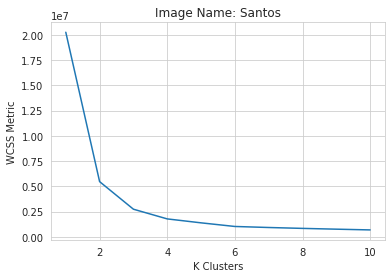

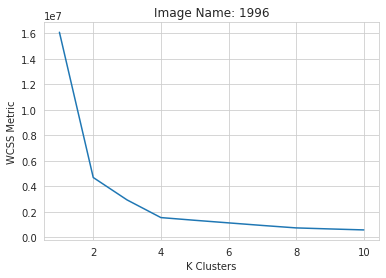

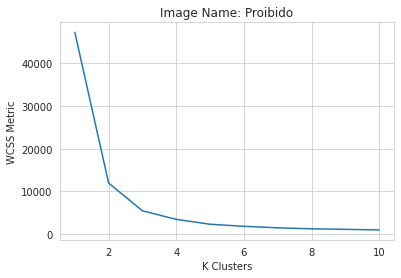

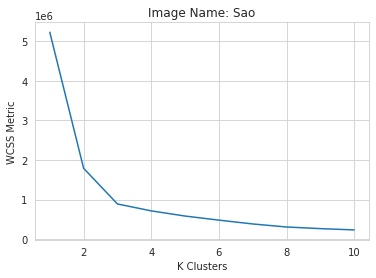

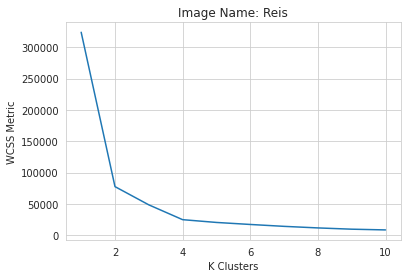

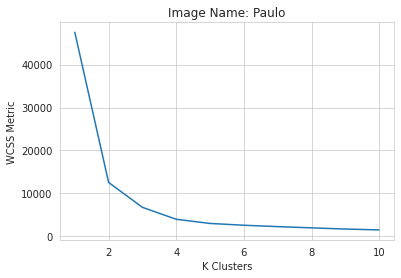

In [17]:
show_wcss(thresh_images)